In [1]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile, mkdir
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)

# 生成VTK文件内容
def generate_vtk(data, filename):
    with open(filename, 'w') as vtk_file:
        vtk_file.write("# vtk DataFile Version 3.0\n")
        vtk_file.write("Curve data\n")
        vtk_file.write("ASCII\n")
        vtk_file.write("DATASET POLYDATA\n")
        
        # 写入点数据
        num_points = len(data)
        vtk_file.write(f"POINTS {num_points} float\n")
        # for index, row in data.iterrows():
            # vtk_file.write(f"{row['x']} {row['y']} {row['z']}\n")
        for row in data:
            vtk_file.write(f"{row[0]} {row[1]} {row[2]}\n")
        
        # 写入拓扑数据
        vtk_file.write(f"LINES 1 {num_points + 1}\n")
        vtk_file.write(f"{num_points} " + " ".join(map(str, range(num_points))) + "\n")
        
        # # 写入点数据属性
        # vtk_file.write(f"POINT_DATA {num_points}\n")
        
        # # 写入 r 数据
        # vtk_file.write("SCALARS r float 1\n")
        # vtk_file.write("LOOKUP_TABLE default\n")
        # for value in data['r']:
        #     vtk_file.write(f"{value}\n")
        
        # # 写入 curvature 数据
        # vtk_file.write("SCALARS curvature float 1\n")
        # vtk_file.write("LOOKUP_TABLE default\n")
        # for value in data['curvature']:
        #     vtk_file.write(f"{value}\n")
        
        # # 写入 torsion 数据
        # vtk_file.write("SCALARS torsion float 1\n")
        # vtk_file.write("LOOKUP_TABLE default\n")
        # for value in data['torsion']:
        #     vtk_file.write(f"{value}\n")


def compute_centroid(curves):
    centroid = np.mean(curves, axis=0)
    return np.array(centroid)
def translate_to_centroid(curves):
    centroid = compute_centroid(curves)
    new_curves = []
    for i in range(len(curves)):
        new_curves.append(curves[i] - centroid)
    return np.array(new_curves)

import numpy as np

def compute_curve_length(points):
    """
    计算一条形状为 (n, 3) 的 3D 曲线的长度

    参数:
    points (numpy.ndarray): 一个形状为 (n, 3) 的数组，其中每一行是 3D 空间中的一个点

    返回:
    float: 曲线的总长度
    """
    # 计算相邻点的差值
    diffs = np.diff(points, axis=0)
    
    # 计算每个差值的欧几里得距离（即两点之间的距离）
    segment_lengths = np.linalg.norm(diffs, axis=1)
    
    # 累加所有段的长度
    total_length = np.sum(segment_lengths)
    
    return total_length


INFO: Using numpy backend


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


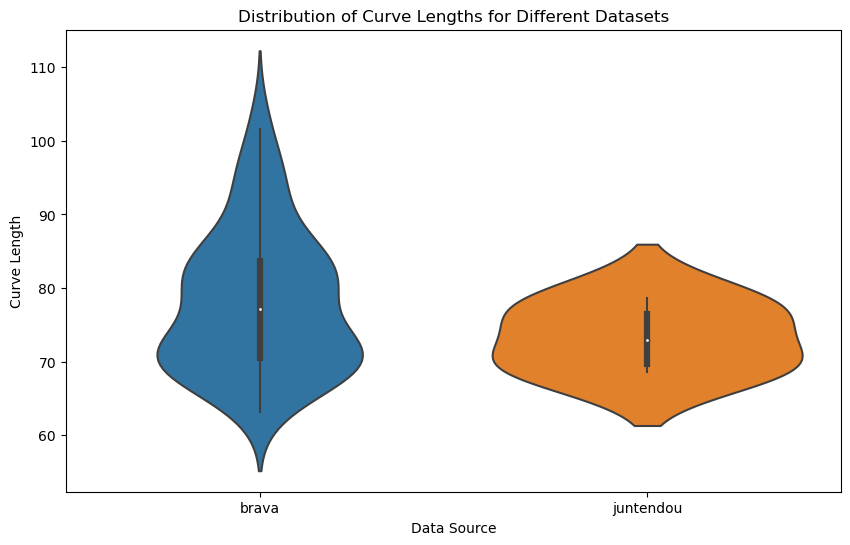

In [75]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# 获取所有文件
brava_files = glob.glob('../brava_ica_mirrored/*.vtk')
juntendou_files = glob.glob('../juntendou_mirroed/*.vtk')
aneurisk_files = glob.glob('../aneurisk_60_mirrored/*.vtk')
# aneurisk_files = []
total_files = brava_files + juntendou_files

# 设置重新采样点数
resample_num = 120

# 定义空列表存储长度信息
brava_lengths = []
juntendou_lengths = []
aneurisk_lengths = []
curves = []
aneurisk_curves = []
# 计算 brava 数据集的曲线长度
for file in brava_files:
    temp = Get_simple_vtk(file)
    temp = translate_to_centroid(temp)
    temp_func = parameterize_curve(temp)
    t_resampled = np.linspace(0, 1, resample_num)
    resampled_curve = temp_func(t_resampled)
    brava_lengths.append(compute_curve_length(resampled_curve))
    curves.append(resampled_curve)

# 计算 juntendou 数据集的曲线长度
for file in juntendou_files:
    temp = Get_simple_vtk(file)
    temp = translate_to_centroid(temp)
    temp_func = parameterize_curve(temp)
    t_resampled = np.linspace(0, 1, resample_num)
    resampled_curve = temp_func(t_resampled)
    juntendou_lengths.append(compute_curve_length(resampled_curve))
    curves.append(resampled_curve)

# 计算 aneurisk 数据集的曲线长度
for file in aneurisk_files:
    temp = Get_simple_vtk(file)
    temp = translate_to_centroid(temp)
    temp_func = parameterize_curve(temp)
    t_resampled = np.linspace(0, 1, resample_num)
    resampled_curve = temp_func(t_resampled)
    aneurisk_lengths.append(compute_curve_length(resampled_curve))
    aneurisk_curves.append(resampled_curve)

# 将三组数据整合为一个长格式的列表，供 Seaborn 进行绘图
all_lengths = brava_lengths + juntendou_lengths
data_source = (['brava'] * len(brava_lengths) + 
               ['juntendou'] * len(juntendou_lengths))

# 使用 seaborn 绘制 violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(x=data_source, y=all_lengths)
plt.title('Distribution of Curve Lengths for Different Datasets')
plt.xlabel('Data Source')
plt.ylabel('Curve Length')
plt.show()

curves = np.array(curves)
aneurisk_curves = np.array(aneurisk_curves)

(83, 360)
(83, 3)


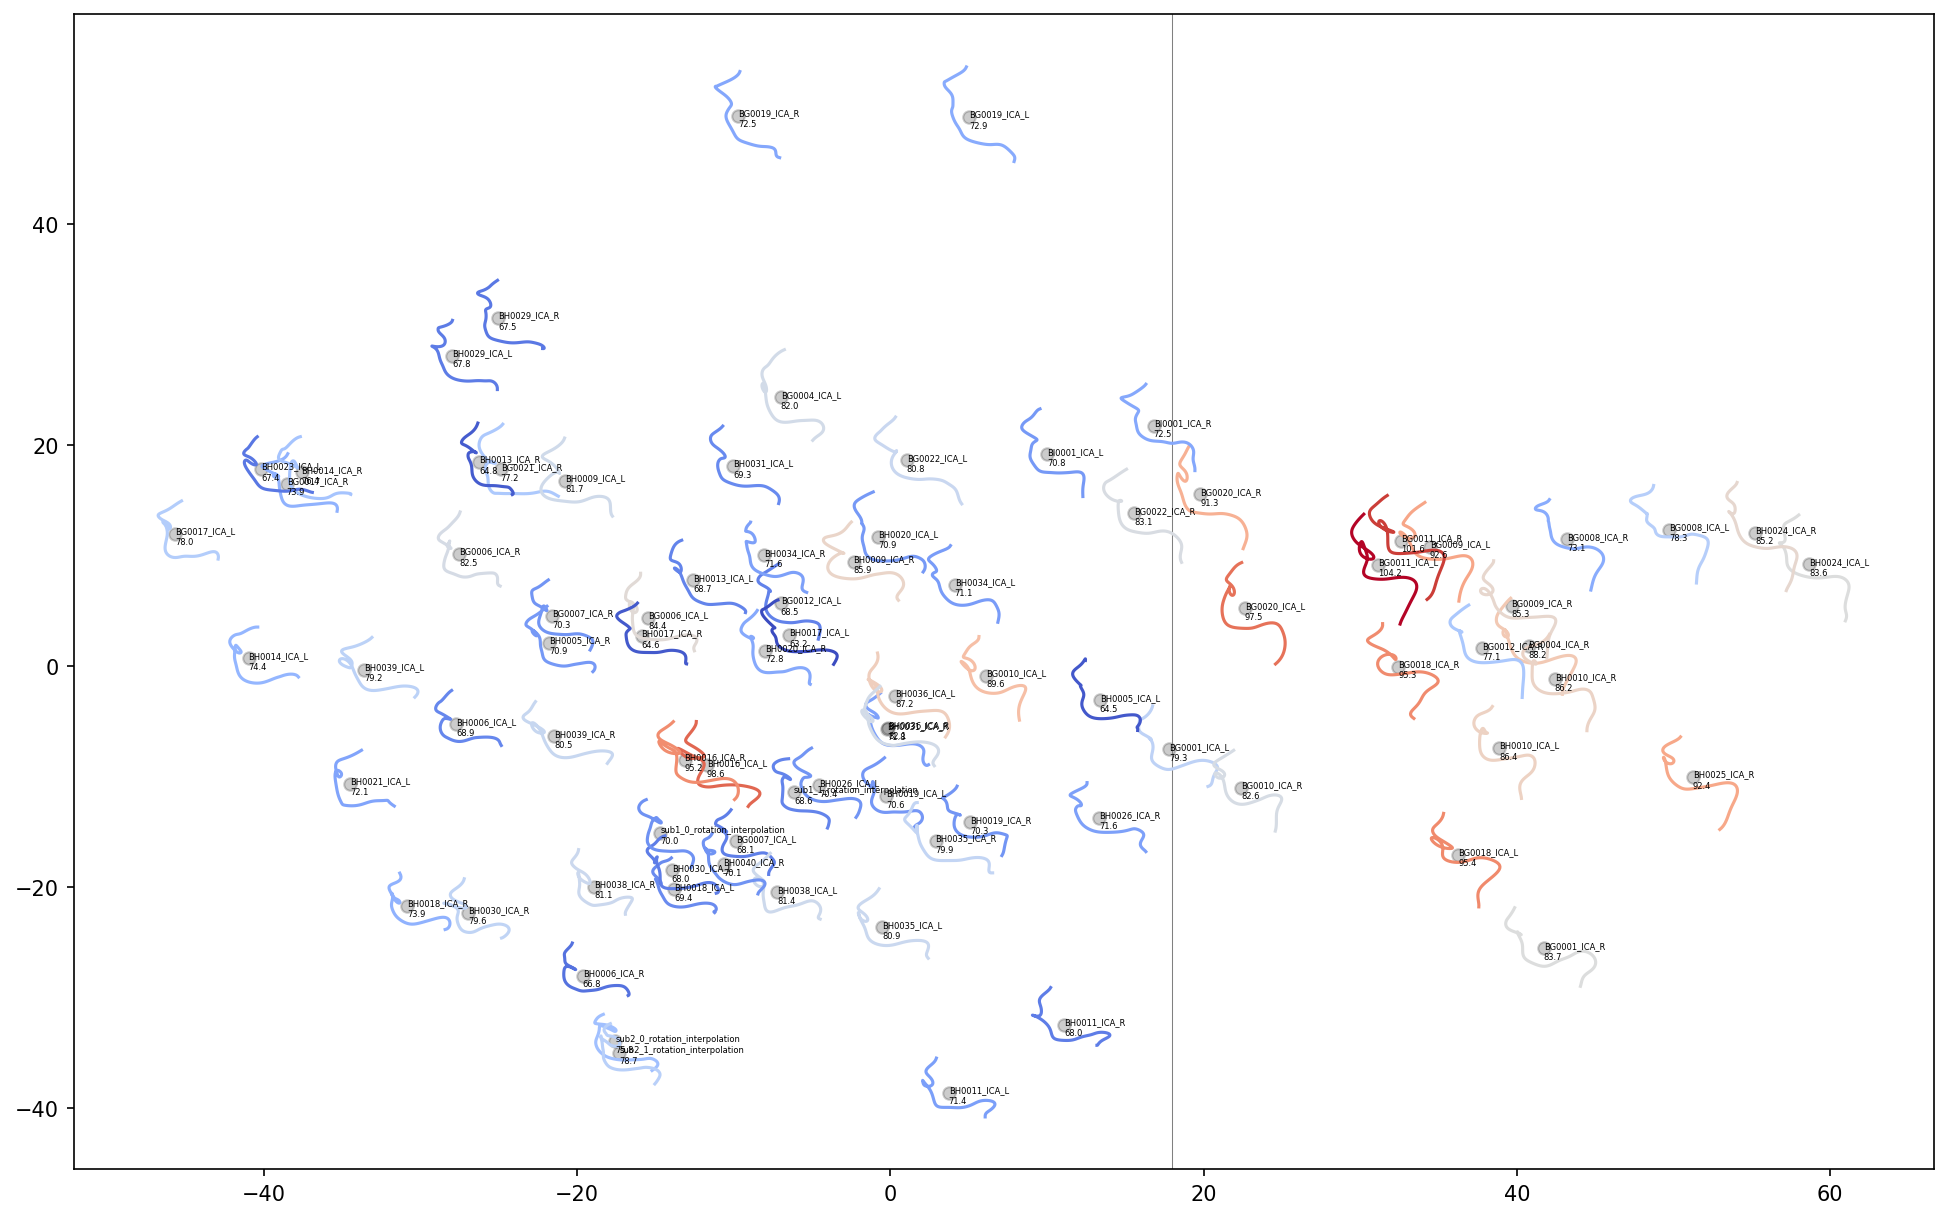

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sklearn.decomposition import PCA

# 创建颜色映射器，基于曲线长度映射到颜色
norm = plt.Normalize(vmin=min(all_lengths), vmax=max(all_lengths))
colormap = cm.coolwarm  # 你可以选择其他 colormap，例如 'plasma', 'cool', 'hot'


pca = PCA(n_components=3)
print (curves.reshape(len(total_files),-1).shape)
result = pca.fit_transform(curves.reshape(len(total_files),-1))
print (result.shape)

fig = plt.figure(figsize=(16, 10),dpi=150)
ax = fig.add_subplot(111)
ax.scatter(result[:, 0], result[:, 1],c="k",alpha=0.2)
ax.axvline(18, color='grey', lw=0.5)
for i in range(len(all_lengths)):
    filename = total_files[i].split('\\')[-1].split('.')[0]
    color = colormap(norm(all_lengths[i]))  
    # print (filename)
    icon_curve =translate_to_centroid(curves[i]) * 0.2 + result[i]
    ax.text(result[i, 0], result[i, 1]-1, str(round(all_lengths[i], 1)),fontsize=4,color='k')
    ax.text(result[i, 0], result[i, 1], filename,fontsize=4,color='k')
    ax.plot(icon_curve[:,0],icon_curve[:,1],color=color)
plt.show()



(36, 3)


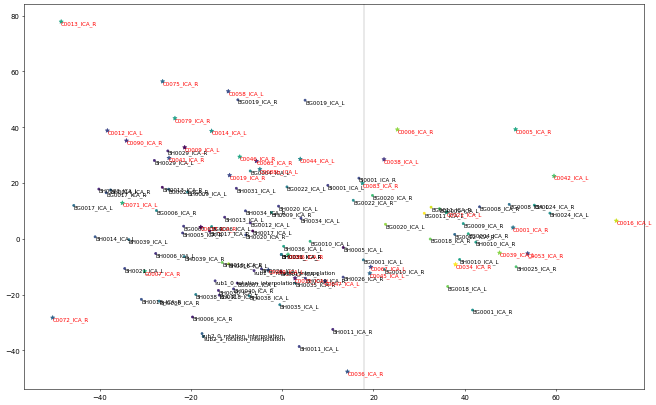

In [179]:
a_result = pca.transform(aneurisk_curves.reshape(len(aneurisk_curves),-1))
print (a_result.shape)

fig = plt.figure(figsize=(16, 10),dpi=50)
ax = fig.add_subplot(111)
ax.scatter(result[:, 0], result[:, 1],c=all_lengths,alpha=1,marker='.')
ax.scatter(a_result[:, 0], a_result[:, 1],c=aneurisk_lengths,alpha=1,marker='*')
ax.axvline(18, color='grey', lw=0.5)
for i in range(len(curves)):
    filename = total_files[i].split('\\')[-1].split('.')[0]
    ax.text(result[i, 0], result[i, 1]-1, str(filename),fontsize=8,color='k')
for i in range(len(aneurisk_curves)):
    filename = aneurisk_files[i].split('\\')[-1].split('.')[0]
    ax.text(a_result[i, 0], a_result[i, 1]-1, str(filename),fontsize=8,color='r')
plt.show()

符合条件的曲线数量: 64
(64, 3)


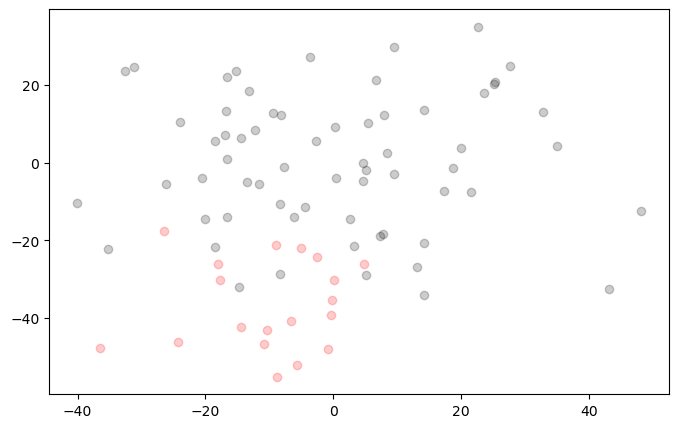

In [186]:
# 创建一个列表来保存符合条件的曲线
good_curves = []
bad_curves = []
good_files = []
bad_files = []
# 抽取第一主成分大于 19 的曲线
for i in range(len(result)):
    if result[i, 0] < 19:  # 第一主成分
        good_curves.append(curves[i])  # 将符合条件的曲线保存到 good_curves
        good_files.append(total_files[i])
    else:
        bad_curves.append(curves[i])
        bad_files.append(total_files[i])

# 打印符合条件的曲线数量
print(f"符合条件的曲线数量: {len(good_curves)}")

good_pca = PCA(n_components=3)
good_result = good_pca.fit_transform(np.array(good_curves).reshape(len(good_curves),-1))
print (good_result.shape)
bad_result = good_pca.transform(np.array(bad_curves).reshape(len(bad_curves),-1))


fig = plt.figure(figsize=(8,5),dpi=100)
ax = fig.add_subplot(111)
ax.scatter(good_result[:, 0], good_result[:, 1],c="k",alpha=0.2)
ax.scatter(bad_result[:, 0], bad_result[:, 1],c="r",alpha=0.2)
# ax.axvline(18, color='grey', lw=0.5)
plt.show()


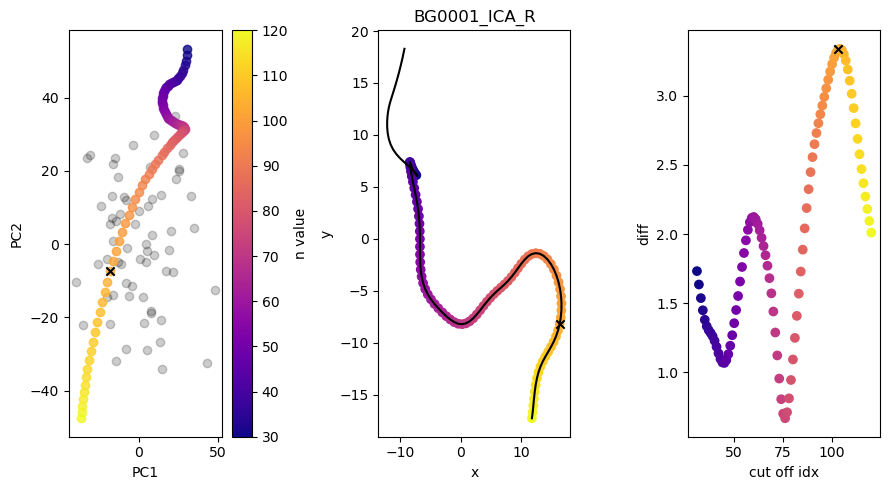

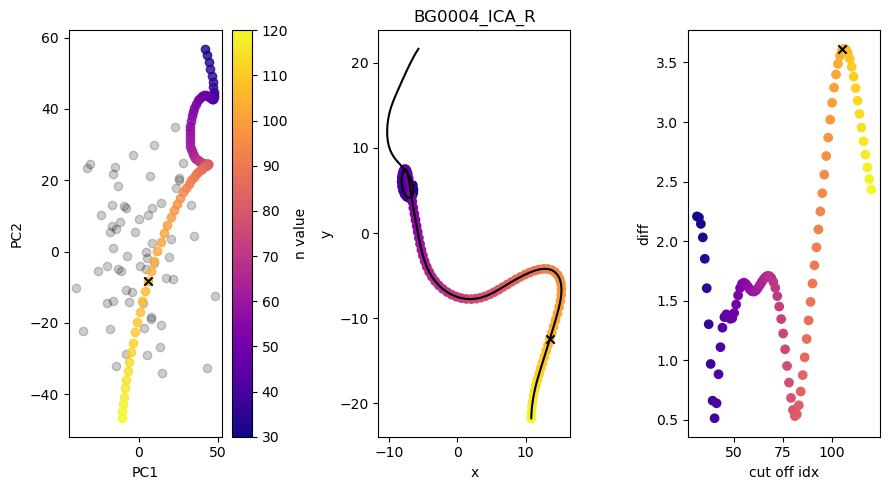

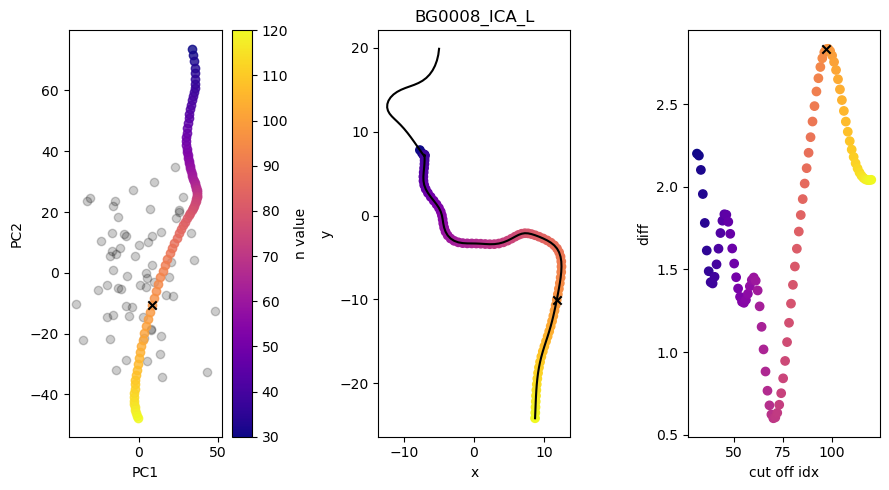

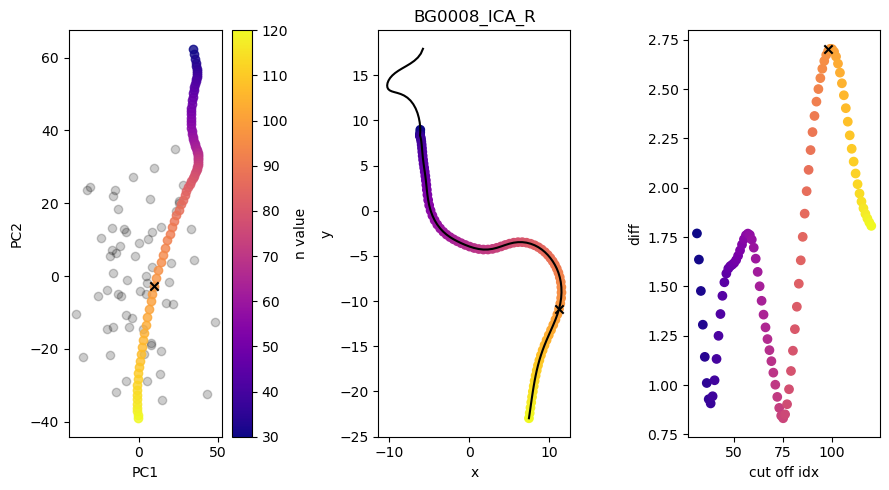

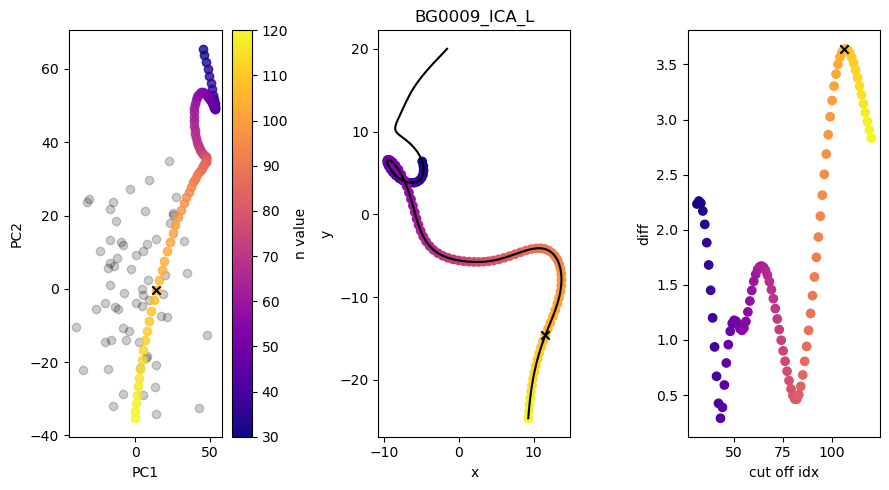

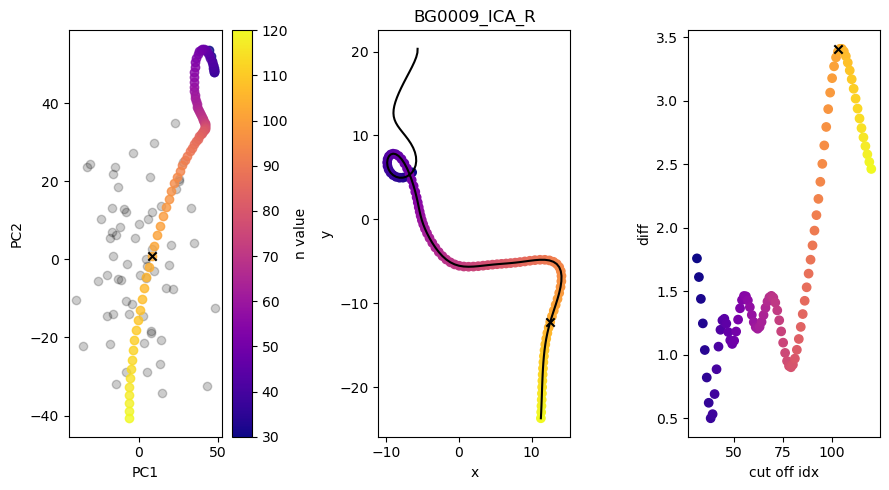

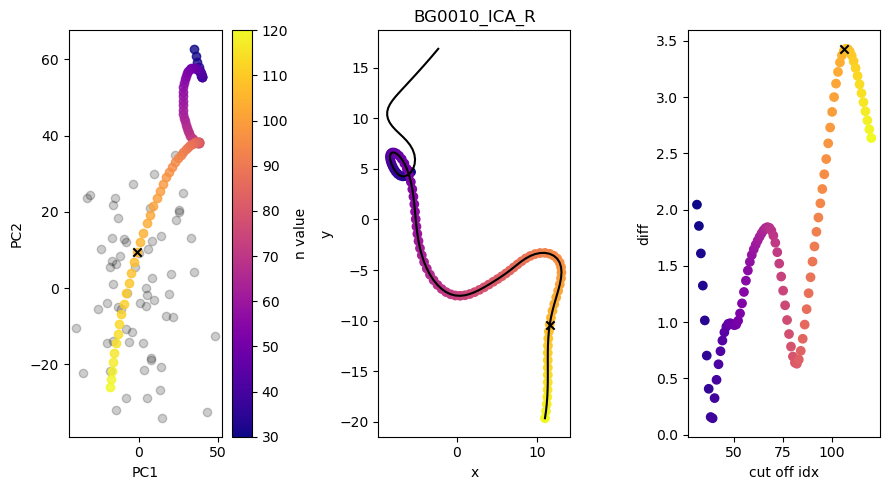

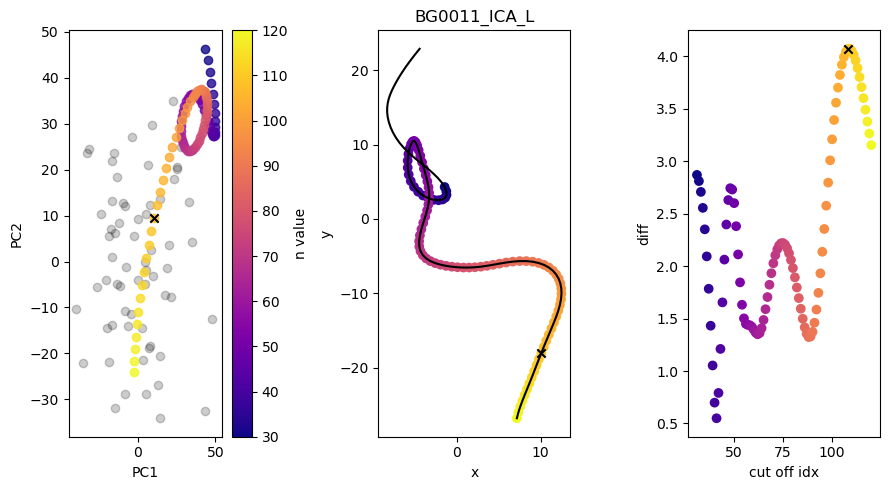

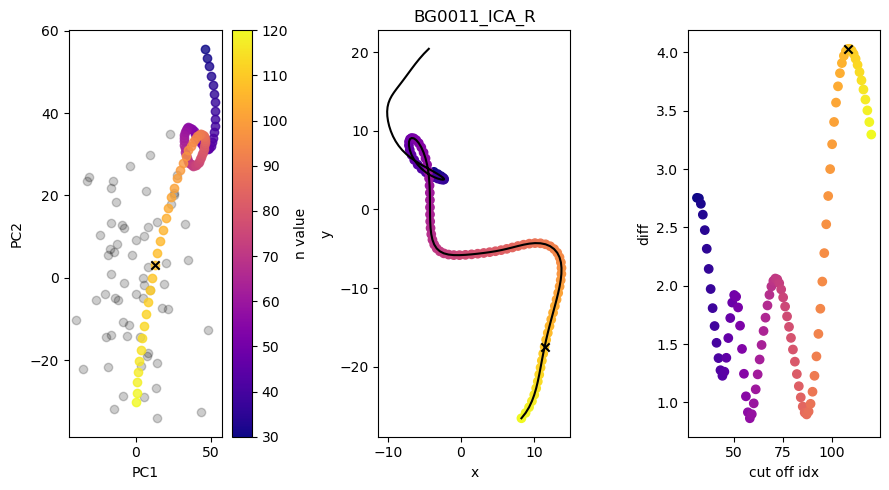

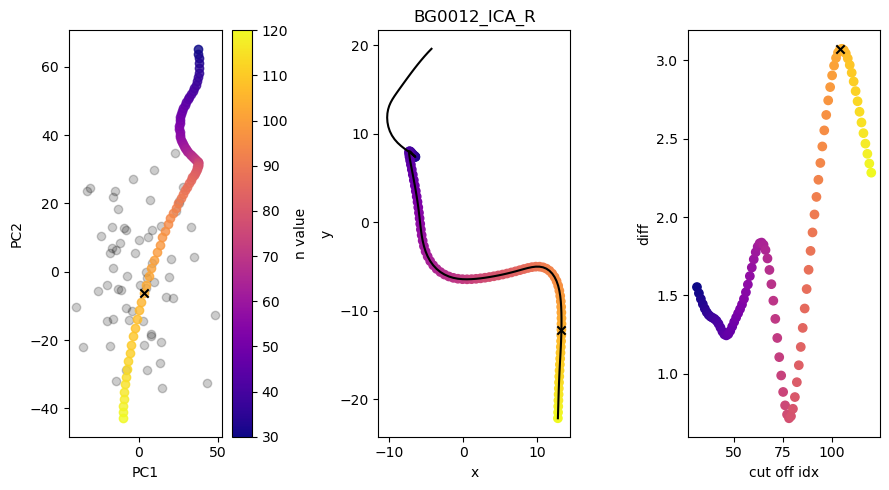

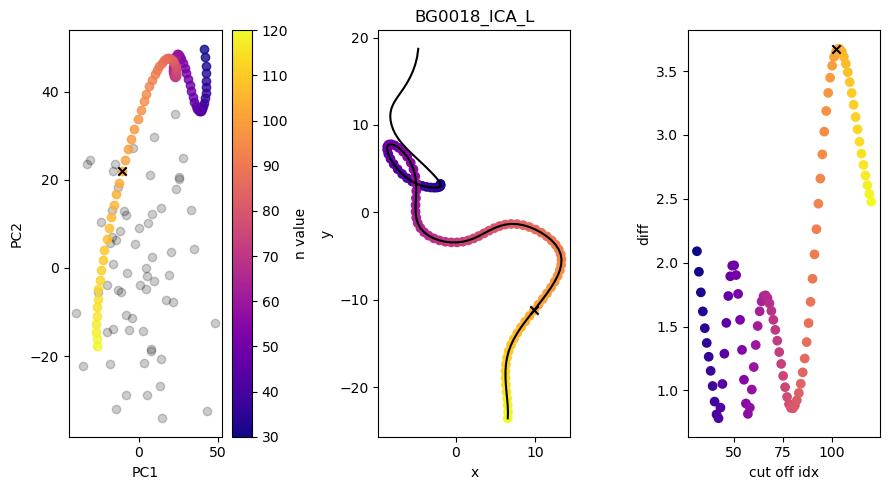

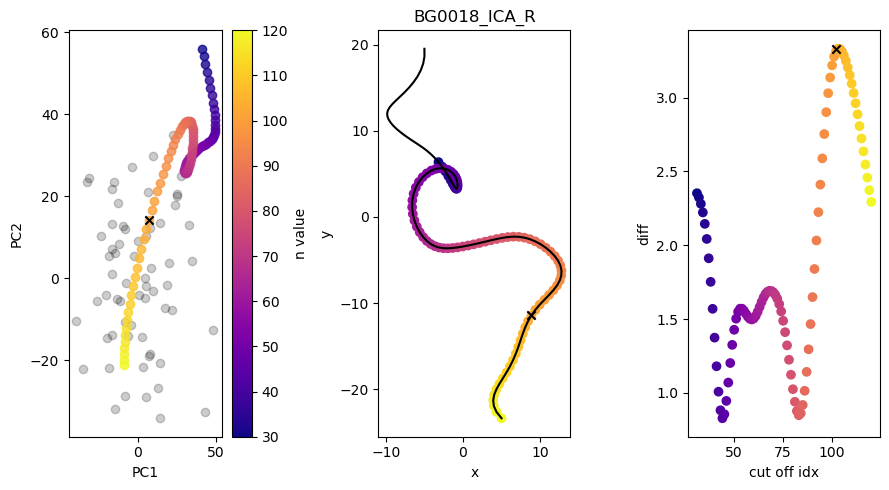

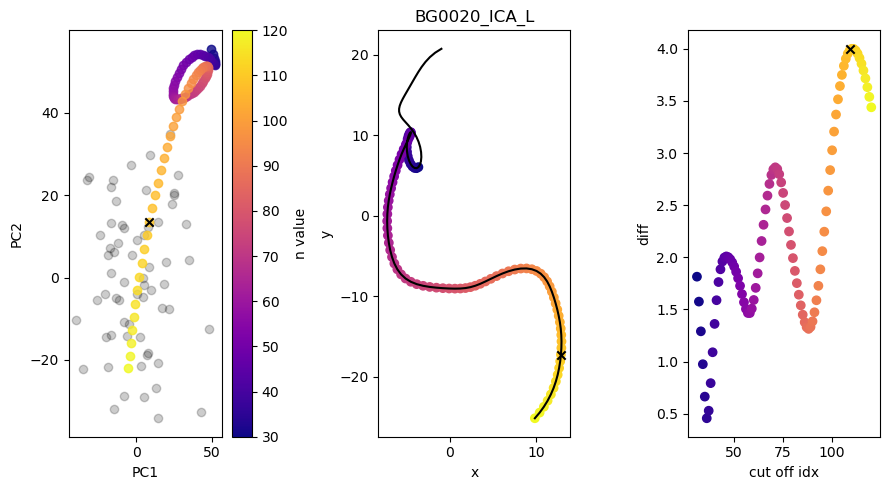

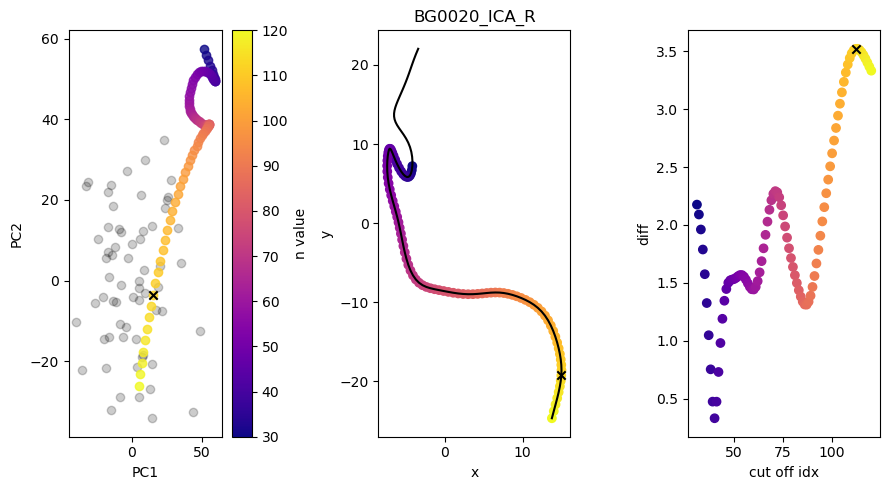

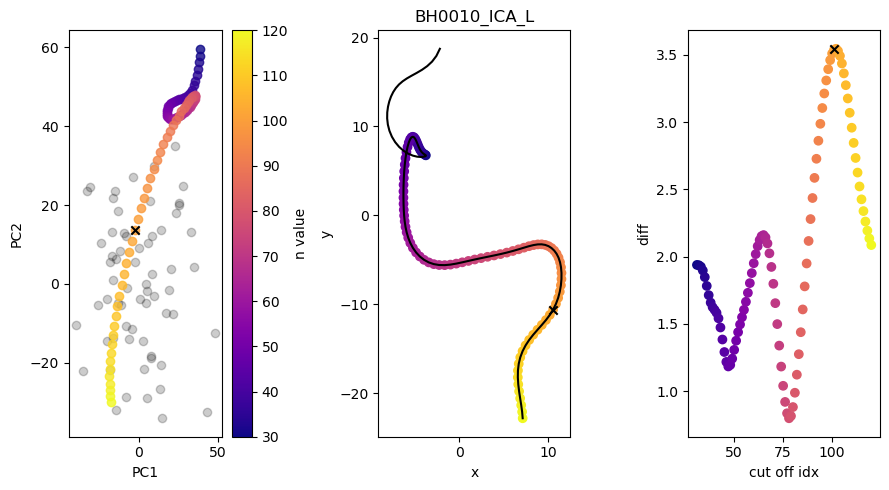

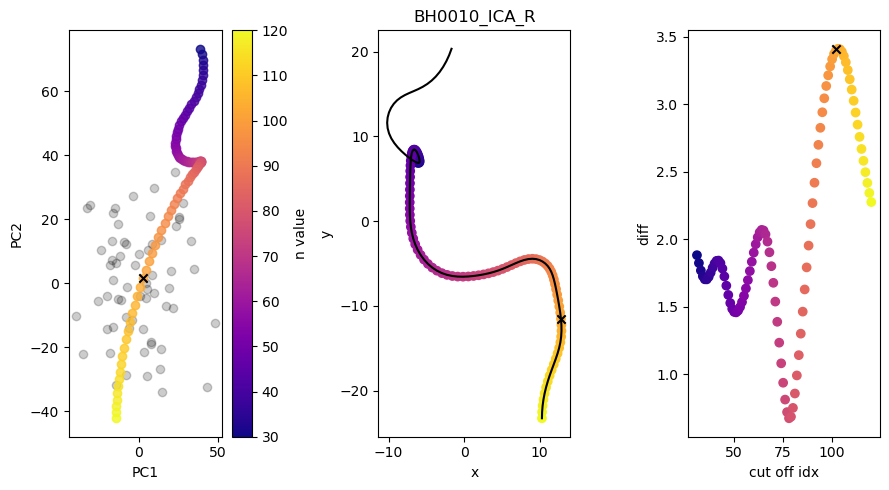

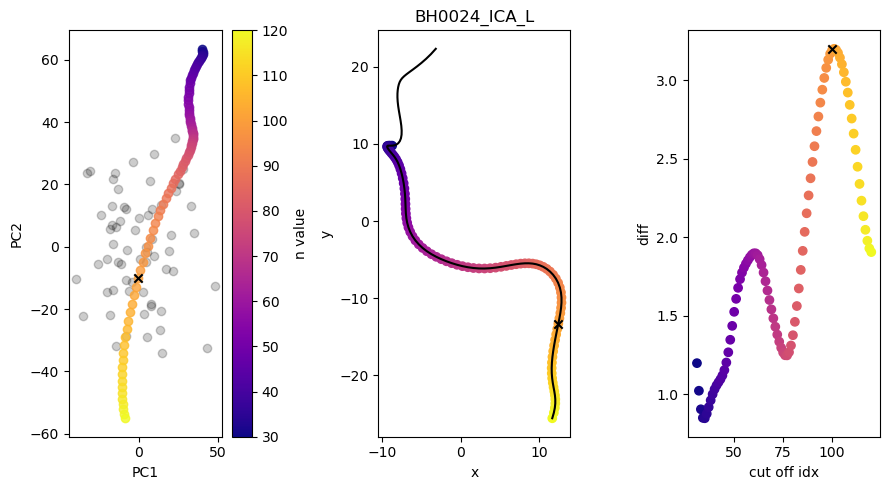

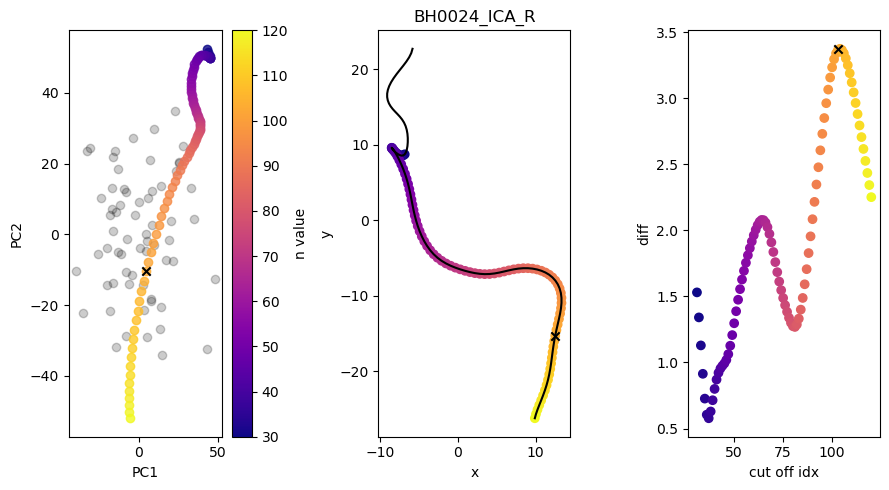

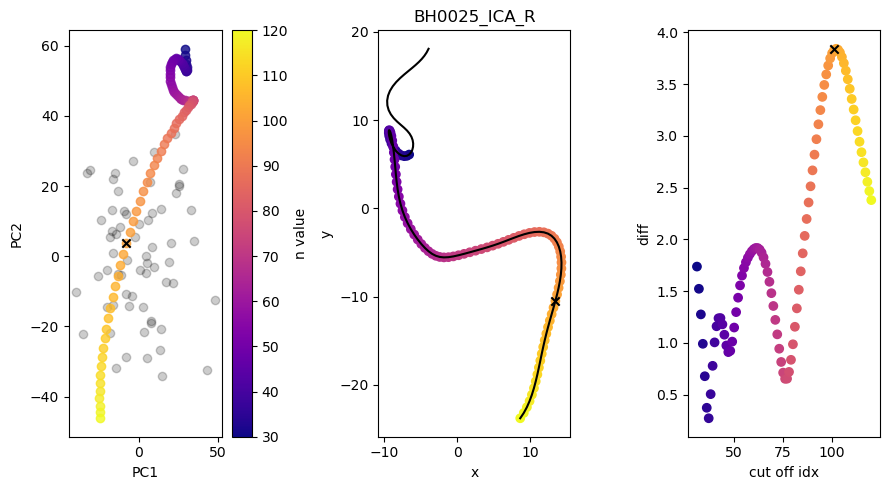

In [187]:
bad_curves_cutoff = []

for i in range(len(bad_curves)):
    filename = bad_files[i].split('\\')[-1].split('.')[0]
    temp_curve = bad_curves[i]
    n_max = 120
    n_min = 30

    # 设置 n 的范围
    n_values = range(n_min, n_max + 1)

    # 创建图像
    fig = plt.figure(figsize=(9, 5), dpi=100)
    ax = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax2.plot(temp_curve[:,0],temp_curve[:,1], color='k')
    # 绘制背景的 good_result 点
    ax.scatter(good_result[:, 0], good_result[:, 1], c="k", alpha=0.2)
    ax2.scatter(temp_curve[n_min:n_max,0],temp_curve[n_min:n_max,1],cmap="plasma",c=range(n_min,n_max))

    # 设置颜色映射器
    norm = plt.Normalize(vmin=n_min, vmax=n_max)
    colormap = cm.plasma  # 你可以选择其他 colormap, 例如 'viridis', 'plasma', 'inferno', 'cool'
    # 用于存储每个 temp_result 的位置
    temp_results = []
    # 迭代 n 的不同值并绘制 temp_result 的轨迹
    for n in n_values:
        # 截取 temp_curve 的前 n 个点
        temp_curves_cut = temp_curve[0:n]
        
        # 重新参数化曲线
        temp_func = parameterize_curve(temp_curves_cut)
        t_resampled = np.linspace(0, 1, resample_num)
        resampled_curve = temp_func(t_resampled)
        
        # 通过 PCA 进行转换
        temp_result = good_pca.transform(resampled_curve.reshape(1, -1))
        temp_results.append(temp_result)
        
        # 通过颜色映射器获取渐变颜色
        color = colormap(norm(n))
        
        # 绘制 temp_result 点，使用渐变颜色
        ax.scatter(temp_result[:, 0], temp_result[:, 1], color=color, alpha=0.8)
    
    temp_results = np.array(temp_results)
    # print (temp_results.shape)
    diffs = np.linalg.norm(np.diff(temp_results, axis=0), axis=2)
    ax3.scatter(n_values[1:], diffs, c=range(n_min, n_max), cmap=colormap)
    # 找到变化率开始变大的点（例如通过变化率的二阶导数）
    # change_rate_of_diffs = np.diff(diffs)
    # print (diffs)
    cut_off = n_min + np.argmax(diffs)
    bad_curves_cutoff.append(n_min + np.argmax(diffs))
    ax2.scatter(temp_curve[cut_off,0],temp_curve[cut_off,1],color='k',marker="x")
    ax3.scatter(cut_off, diffs[cut_off-n_min], c='k', marker='x')
    ax.scatter(temp_results[np.argmax(diffs), 0,0], temp_results[np.argmax(diffs), 0,1], c='k', marker='x')
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='n value')
    ax2.set_title(filename)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax3.set_xlabel('cut off idx')
    ax3.set_ylabel('diff')
    fig.tight_layout()
    plt.show()


In [188]:
print (bad_curves_cutoff)

brava_cut_mirrored_dir = mkdir('../', 'brava_cut_mirrored')

for i in range(len(bad_curves_cutoff)):
    filename = bad_files[i].split('\\')[-1].split('.')[0]
    print (filename)
    temp_curve = bad_curves[i]
    print (compute_curve_length(temp_curve))
    n = bad_curves_cutoff[i]
    temp_curves_cut = temp_curve[0:n]
    print (compute_curve_length(temp_curves_cut))
    print ("---")
    temp_func = parameterize_curve(temp_curves_cut)
    t_resampled = np.linspace(0, 1, resample_num)
    resampled_curve = temp_func(t_resampled)
    # makeVtkFile(brava_cut_mirrored_dir+'{}.vtk'.format(filename),resampled_curve, [])

for i in range(len(good_curves)):
    filename=good_files[i].split('\\')[-1].split('.')[0]
    temp_curve = good_curves[i]
    # makeVtkFile(brava_cut_mirrored_dir+'{}.vtk'.format(filename),temp_curve, [])


[103, 105, 97, 98, 106, 103, 106, 108, 108, 104, 102, 102, 109, 112, 101, 102, 100, 103, 101]
BG0001_ICA_R
83.66607331192186
71.27073156513538
---
BG0004_ICA_R
88.15491656961797
76.83186475977584
---
BG0008_ICA_L
78.3050849932048
62.6197572827654
---
BG0008_ICA_R
73.11090472561999
59.21362951859678
---
BG0009_ICA_L
92.64228492019264
81.15794321658514
---
BG0009_ICA_R
85.32166155072815
72.54035848639705
---
BG0010_ICA_R
82.62850513073269
72.30793158842738
---
BG0011_ICA_L
104.20896815884237
93.29930001695573
---
BG0011_ICA_R
101.56270927501558
90.6149785292677
---
BG0012_ICA_R
77.1427734530409
66.33482602484904
---
BG0018_ICA_L
95.42907114072973
80.29258767463415
---
BG0018_ICA_R
95.33593230761389
80.37948566026574
---
BG0020_ICA_L
97.49622254209443
87.91695249202255
---
BG0020_ICA_R
91.25809778791943
84.82384676047165
---
BH0010_ICA_L
86.44886371043913
71.88462039273224
---
BH0010_ICA_R
86.18085795203964
72.71563525340262
---
BH0024_ICA_L
83.55695479250609
69.15051351576147
---
BH0024_

符合条件的曲线数量: 24
不符合条件的曲线数量: 12


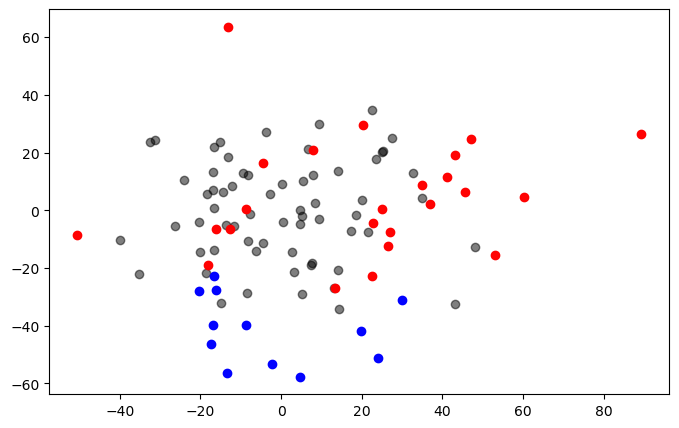

In [190]:
# 创建一个列表来保存符合条件的曲线
good_aneurisk = []
bad_aneurisk = []
good_files_aneurisk = []
bad_files_aneurisk = []
# 抽取第一主成分大于 19 的曲线
for i in range(len(a_result)):
    if a_result[i, 0] < 19:  # 第一主成分
        good_aneurisk.append(aneurisk_curves[i])  # 将符合条件的曲线保存到 good_curves
        good_files_aneurisk.append(aneurisk_files[i])
        # print ("!!")
    else:
        bad_aneurisk.append(aneurisk_curves[i])
        bad_files_aneurisk.append(aneurisk_files[i])
        # print ("??")

# 打印符合条件的曲线数量
print(f"符合条件的曲线数量: {len(good_aneurisk)}")
print(f"不符合条件的曲线数量: {len(bad_aneurisk)}")


bad_aneurisk_result = good_pca.transform(np.array(bad_aneurisk).reshape(len(bad_aneurisk),-1))
good_aneurisk_result = good_pca.transform(np.array(good_aneurisk).reshape(len(good_aneurisk),-1))


fig = plt.figure(figsize=(8,5),dpi=100)
ax = fig.add_subplot(111)
ax.scatter(good_result[:, 0], good_result[:, 1],c="k",alpha=0.5)
ax.scatter(good_aneurisk_result[:, 0], good_aneurisk_result[:, 1],c="r",alpha=0.99)
ax.scatter(bad_aneurisk_result[:, 0], bad_aneurisk_result[:, 1],c="b",alpha=0.99)
plt.show()

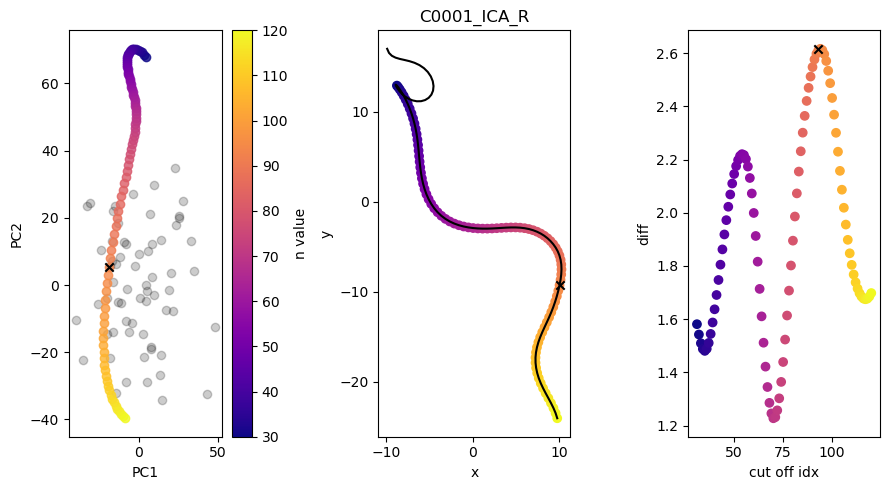

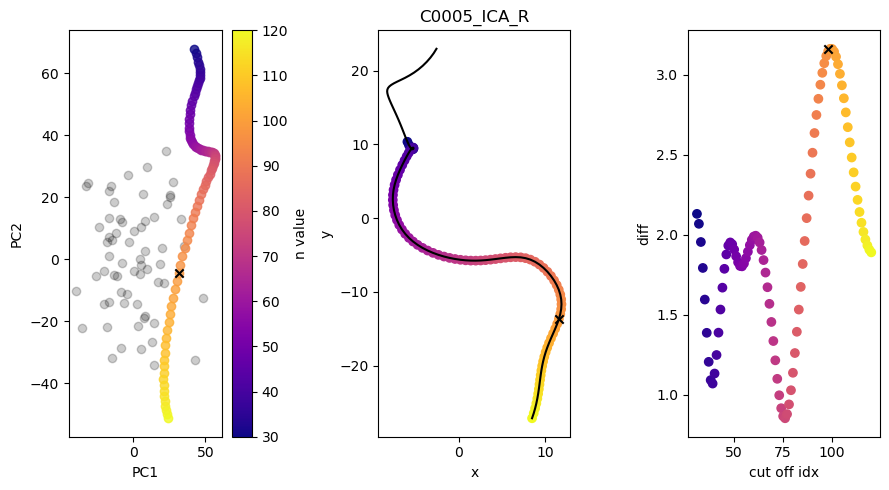

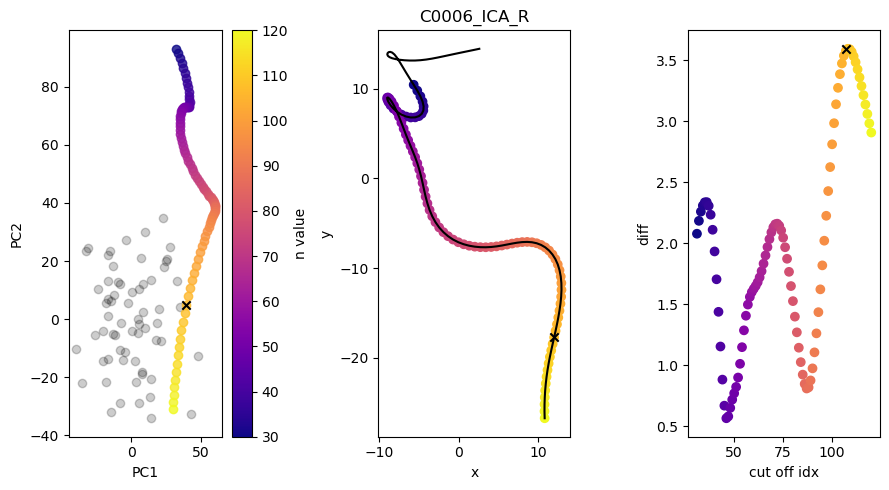

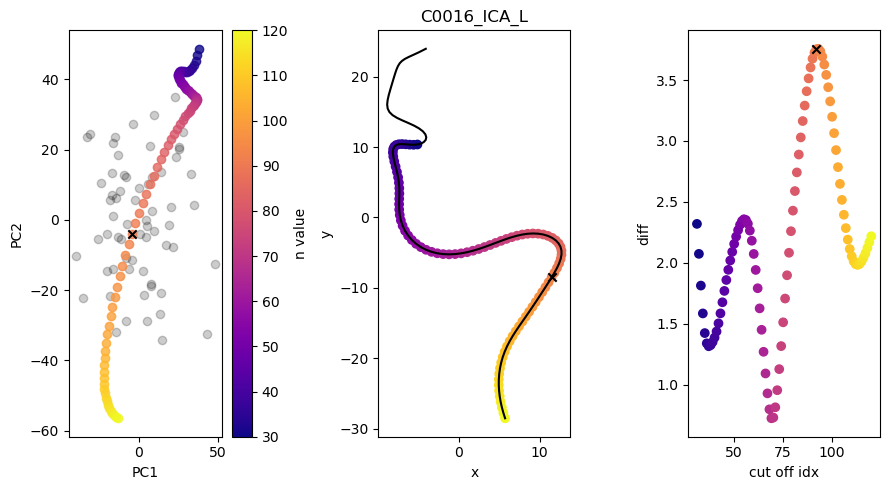

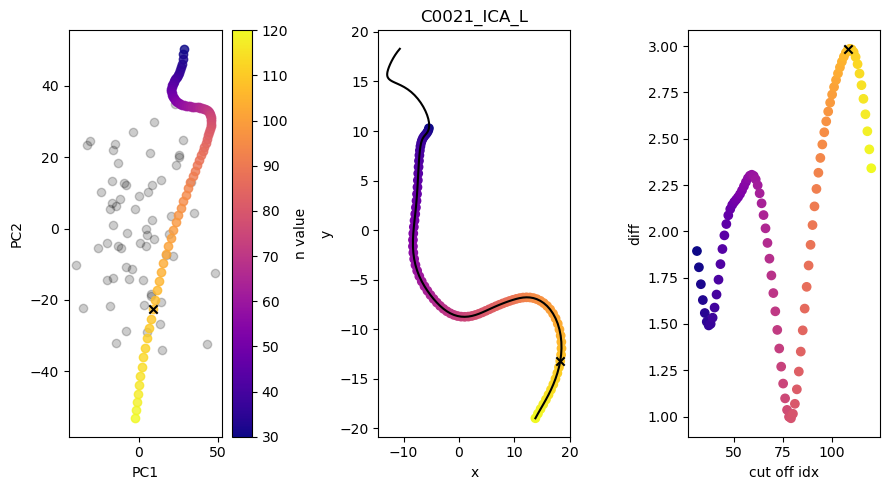

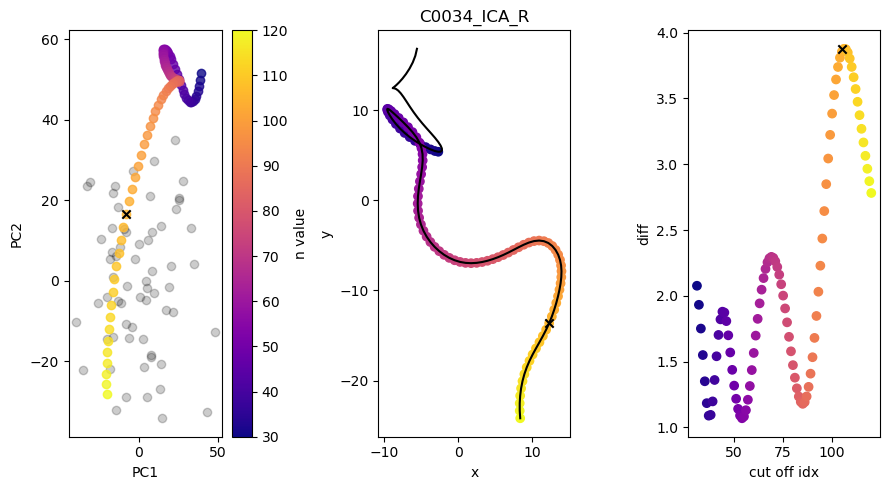

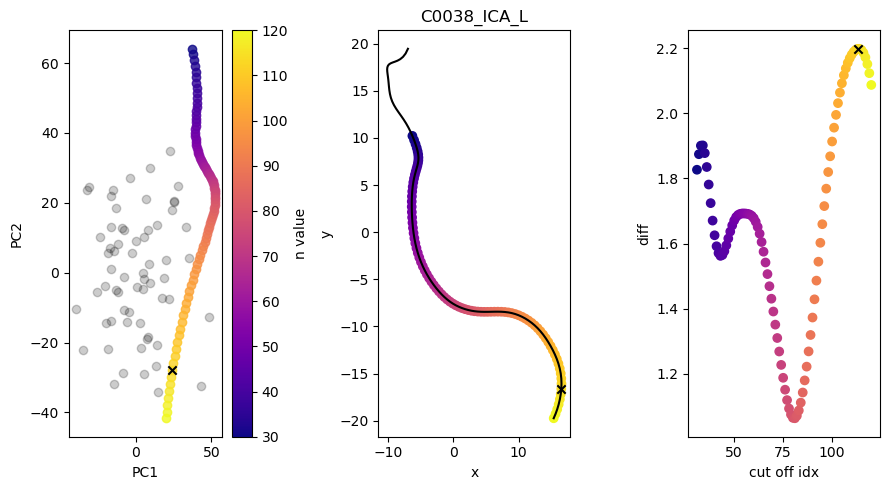

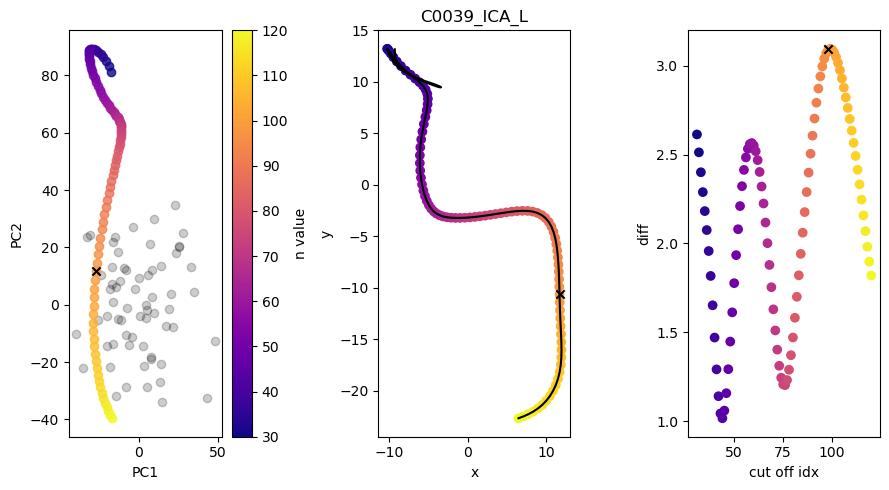

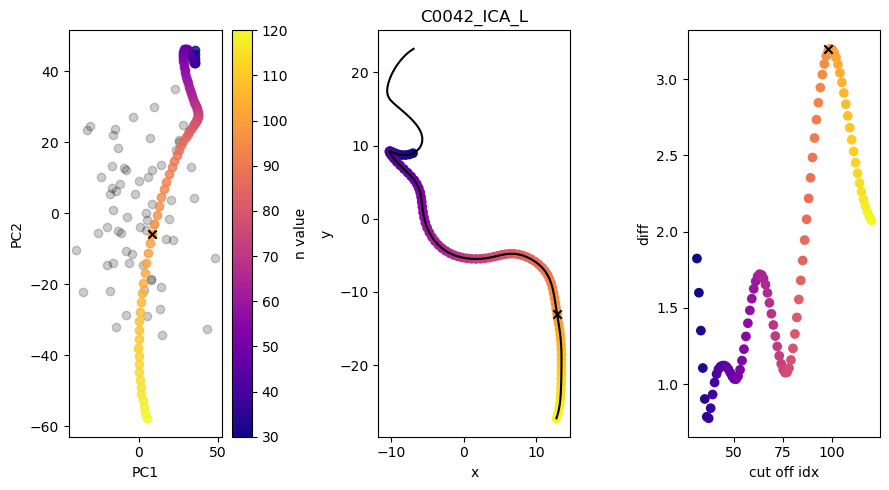

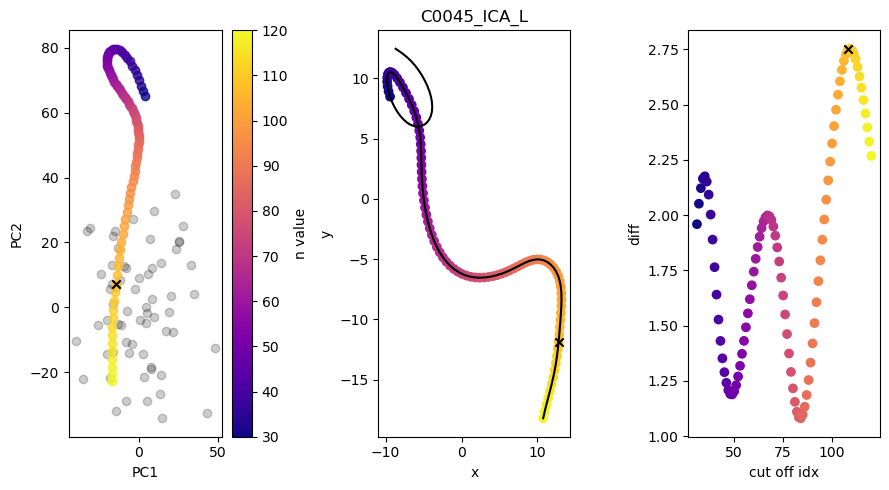

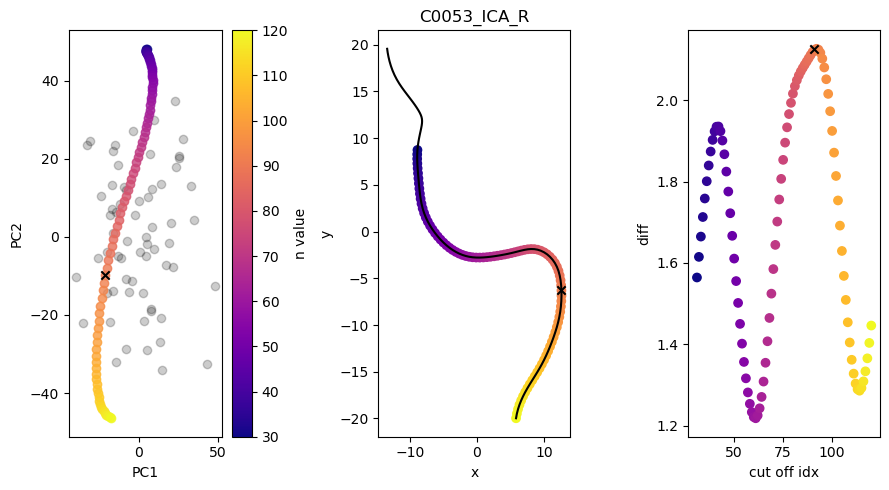

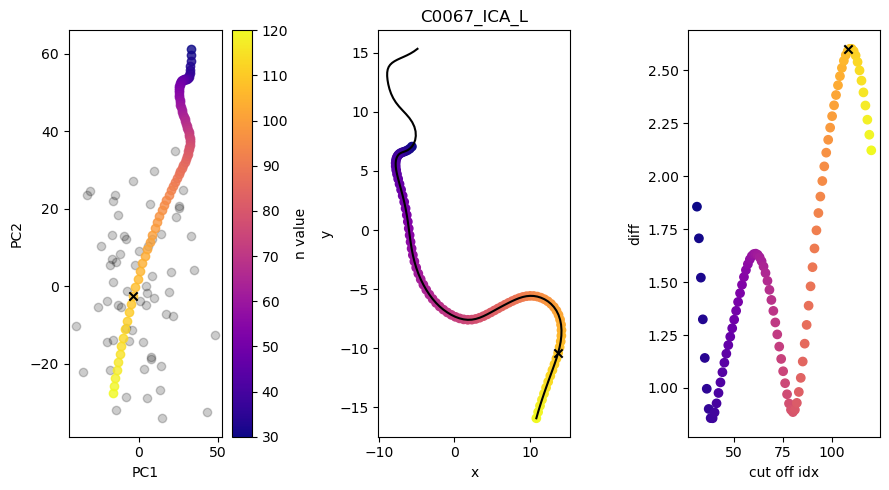

In [194]:
bad_aneurisk_cutoff = []

for i in range(len(bad_files_aneurisk)):
    filename = bad_files_aneurisk[i].split('\\')[-1].split('.')[0]
    temp_curve = bad_aneurisk[i]
    n_max = 120
    n_min = 30

    # 设置 n 的范围
    n_values = range(n_min, n_max + 1)

    # 创建图像
    fig = plt.figure(figsize=(9, 5), dpi=100)
    ax = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax2.plot(temp_curve[:,0],temp_curve[:,1], color='k')
    # 绘制背景的 good_result 点
    ax.scatter(good_result[:, 0], good_result[:, 1], c="k", alpha=0.2)
    ax2.scatter(temp_curve[n_min:n_max,0],temp_curve[n_min:n_max,1],cmap="plasma",c=range(n_min,n_max))

    # 设置颜色映射器
    norm = plt.Normalize(vmin=n_min, vmax=n_max)
    colormap = cm.plasma  # 你可以选择其他 colormap, 例如 'viridis', 'plasma', 'inferno', 'cool'
    # 用于存储每个 temp_result 的位置
    temp_results = []
    # 迭代 n 的不同值并绘制 temp_result 的轨迹
    for n in n_values:
        # 截取 temp_curve 的前 n 个点
        temp_curves_cut = temp_curve[0:n]
        
        # 重新参数化曲线
        temp_func = parameterize_curve(temp_curves_cut)
        t_resampled = np.linspace(0, 1, resample_num)
        resampled_curve = temp_func(t_resampled)
        
        # 通过 PCA 进行转换
        temp_result = good_pca.transform(resampled_curve.reshape(1, -1))
        temp_results.append(temp_result)
        
        # 通过颜色映射器获取渐变颜色
        color = colormap(norm(n))
        
        # 绘制 temp_result 点，使用渐变颜色
        ax.scatter(temp_result[:, 0], temp_result[:, 1], color=color, alpha=0.8)
    
    temp_results = np.array(temp_results)
    # print (temp_results.shape)
    diffs = np.linalg.norm(np.diff(temp_results, axis=0), axis=2)
    ax3.scatter(n_values[1:], diffs, c=range(n_min, n_max), cmap=colormap)
    # 找到变化率开始变大的点（例如通过变化率的二阶导数）
    # change_rate_of_diffs = np.diff(diffs)
    # print (diffs)
    cut_off = n_min + np.argmax(diffs)
    bad_aneurisk_cutoff.append(n_min + np.argmax(diffs))
    ax2.scatter(temp_curve[cut_off,0],temp_curve[cut_off,1],color='k',marker="x")
    ax3.scatter(cut_off, diffs[cut_off-n_min], c='k', marker='x')
    ax.scatter(temp_results[np.argmax(diffs), 0,0], temp_results[np.argmax(diffs), 0,1], c='k', marker='x')
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='n value')
    ax2.set_title(filename)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax3.set_xlabel('cut off idx')
    ax3.set_ylabel('diff')
    fig.tight_layout()
    plt.show()


In [195]:
print (bad_aneurisk_cutoff)

aneurisk_cut_mirrored_dir = mkdir('../', 'aneurisk_cut_mirrored')

for i in range(len(bad_aneurisk_cutoff)):
    filename = bad_files_aneurisk[i].split('\\')[-1].split('.')[0]
    print (filename)
    temp_curve = bad_aneurisk[i]
    print (compute_curve_length(temp_curve))
    n = bad_curves_cutoff[i]
    temp_curves_cut = temp_curve[0:n]
    print (compute_curve_length(temp_curves_cut))
    print ("---")
    temp_func = parameterize_curve(temp_curves_cut)
    t_resampled = np.linspace(0, 1, resample_num)
    resampled_curve = temp_func(t_resampled)
    makeVtkFile(aneurisk_cut_mirrored_dir+'{}.vtk'.format(filename),resampled_curve, [])

for i in range(len(good_aneurisk)):
    filename=good_files_aneurisk[i].split('\\')[-1].split('.')[0]
    temp_curve = good_aneurisk[i]
    makeVtkFile(aneurisk_cut_mirrored_dir+'{}.vtk'.format(filename),temp_curve, [])

[93, 98, 107, 92, 108, 105, 113, 98, 98, 108, 91, 108]
C0001_ICA_R
75.24699043415511
64.49670200854182
---
C0005_ICA_R
83.04576273778805
72.50565725360246
---
C0006_ICA_R
92.01248376347002
74.07452076288833
---
C0016_ICA_L
95.16621077100274
77.40420726378743
---
C0021_ICA_L
82.40931023269175
72.69058555254844
---
C0034_ICA_R
98.28411521447852
84.16797632838525
---
C0038_ICA_L
66.32922721968053
58.510293625967584
---
C0039_ICA_L
91.43653155742074
82.19136166284592
---
C0042_ICA_L
87.41808795155849
78.54753703017225
---
C0045_ICA_L
72.86031160579331
63.028570872175514
---
C0053_ICA_R
69.30605391844998
58.777443540213454
---
C0067_ICA_L
68.6186200731407
58.20385182033927
---
